In [2]:
pip install tensorflow

  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 3.10.0
    Uninstalling importlib-metadata-3.10.0:
      Successfully uninstalled importlib-metadata-3.10.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
from fredapi import Fred

import pandas as pd
from numpy import array
from sklearn.metrics import mean_squared_error
from statistics import *
import re
from datetime import timedelta
import matplotlib.pyplot as plt
import statsmodels.api as sm

from timeit import default_timer as timer
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [3]:
f = open('C:\\Users\\m.maraqa\\Desktop\\MMA courses\\Capstone Project - TDAM\\Data Exploration + Code\\FRED API.txt')
key = f.readline()
f.close()
fred = Fred(api_key= key) #Enter your key
data = pd.DataFrame(fred.get_series('SP500')) #Enter table name corresponding to FRED site
data.reset_index(inplace = True)
data.columns = ['Date', 'SP500 Daily Close']
data.dropna(inplace = True)
data.reset_index(inplace = True, drop = True)

data

,Date,SP500 Daily Close
0,2012-12-10,1418.55
1,2012-12-11,1427.84
2,2012-12-12,1428.48
3,2012-12-13,1419.45
4,2012-12-14,1413.58
...,...,...
2512,2022-12-01,4076.57
2513,2022-12-02,4071.70
2514,2022-12-05,3998.84
2515,2022-12-06,3941.26


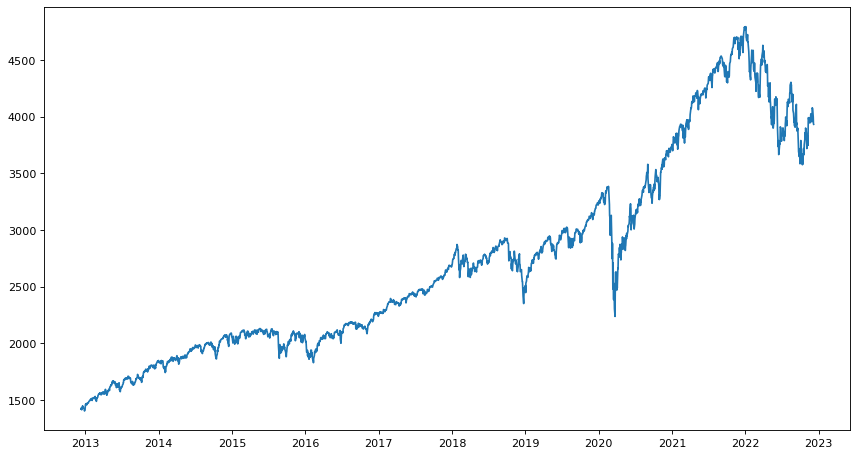

In [4]:
plt.figure(figsize=(13,7),dpi=80)
plt.plot(data.Date,data['SP500 Daily Close'])
plt.show()

In [5]:
#split dataset into train/test (0.7/0.3)
train = data[0:1766]
test = data[1766:2522]

In [6]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [7]:
seq_train = train['SP500 Daily Close'].values
seq_test = test['SP500 Daily Close'].values

# choose a number of time steps
steps_in = 3
steps_out = 1

# split into samples
X_train, y_train = split_sequence(seq_train, steps_in, steps_out)
X_test, y_test = split_sequence(seq_test, steps_in, steps_out)

print("**************************************************************")
print("The input raw sequence on which we will train our CNN model")
print(seq_train)
print("**************************************************************")
print("The features (X) ,lagged values of time series, for training our CNN model")
print(X_train)
print("**************************************************************")
print("The respective observed values (y) of the sequence for training in CNN model")
print(y_train)
print("**************************************************************")
print("The input raw sequence on which we will test our CNN model")
print(seq_test)
print("**************************************************************")
print("The features (X) ,lagged values of time series, for testing our CNN model")
print(X_test)
print("**************************************************************")
print("The respective observed values (y) of the sequence for testing in CNN model")
print(y_test)
print("**************************************************************")

**************************************************************
The input raw sequence on which we will train our CNN model
[1418.55 1427.84 1428.48 ... 3141.63 3168.57 3168.8 ]
**************************************************************
The features (X) ,lagged values of time series, for training our CNN model
[[1418.55 1427.84 1428.48]
 [1427.84 1428.48 1419.45]
 [1428.48 1419.45 1413.58]
 ...
 [3145.91 3135.96 3132.52]
 [3135.96 3132.52 3141.63]
 [3132.52 3141.63 3168.57]]
**************************************************************
The respective observed values (y) of the sequence for training in CNN model
[[1419.45]
 [1413.58]
 [1430.36]
 ...
 [3141.63]
 [3168.57]
 [3168.8 ]]
**************************************************************
The input raw sequence on which we will test our CNN model
[3191.45 3192.52 3191.14 3205.37 3221.22 3224.01 3223.38 3239.91 3240.02
 3221.29 3230.78 3257.85 3234.85 3246.28 3237.18 3253.05 3274.7  3265.35
 3288.13 3283.15 3289.29 3316.81 3329

In [8]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

print(X_train.shape)
print(X_train)
print(y_train.shape, y_train)

(1763, 3, 1)
[[[1418.55]
  [1427.84]
  [1428.48]]

 [[1427.84]
  [1428.48]
  [1419.45]]

 [[1428.48]
  [1419.45]
  [1413.58]]

 ...

 [[3145.91]
  [3135.96]
  [3132.52]]

 [[3135.96]
  [3132.52]
  [3141.63]]

 [[3132.52]
  [3141.63]
  [3168.57]]]
(1763, 1) [[1419.45]
 [1413.58]
 [1430.36]
 ...
 [3141.63]
 [3168.57]
 [3168.8 ]]


In [9]:
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(steps_in,n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(105, activation='relu'))
model.add(Dense(steps_out))
model.compile(optimizer='adam', loss='mse')

In [70]:
model

In [10]:
# fit model
start = timer()
model.fit(X_train, y_train, epochs=32, verbose=0)
end = timer()
print(end - start)

5.917170699999815


In [11]:
y_train_pred = model.predict(X_train, verbose=0)
print(y_train_pred)
mse_train = mean_squared_error(y_train_pred, y_train)

print(f'\nThe in-sample error is ${pow(mse_train,0.5):.2f}')

[[1419.3687]
 [1419.6792]
 [1414.8754]
 ...
 [3120.5044]
 [3117.6995]
 [3134.3923]]

The in-sample error is $26.36


In [15]:
y_test_pred = model.predict(X_test, verbose=0)
print(y_test_pred)
mse_test = mean_squared_error(y_test_pred, y_test)
print(f'\nThe out-of-sample error is ${pow(mse_test,0.5):.2f}')

[[3171.271 ]
 [3178.2102]
 [3191.7725]
 [3201.8708]
 [3202.6313]
 [3211.3562]
 [3219.4944]
 [3219.9087]
 [3213.156 ]
 [3222.9814]
 [3234.158 ]
 [3229.5667]
 [3223.909 ]
 [3227.2075]
 [3241.9377]
 [3252.1782]
 [3258.7454]
 [3266.2876]
 [3266.4595]
 [3281.68  ]
 [3301.357 ]
 [3306.6743]
 [3303.9834]
 [3301.6672]
 [3304.5974]
 [3289.125 ]
 [3261.0405]
 [3255.598 ]
 [3258.0913]
 [3263.2515]
 [3243.231 ]
 [3251.369 ]
 [3293.7183]
 [3318.9622]
 [3322.6018]
 [3325.0596]
 [3333.438 ]
 [3346.591 ]
 [3356.8486]
 [3356.906 ]
 [3357.1873]
 [3359.7502]
 [3362.4893]
 [3358.1526]
 [3336.3992]
 [3261.8206]
 [3162.0486]
 [3109.5608]
 [3035.0073]
 [3015.8574]
 [3061.0078]
 [3081.356 ]
 [3099.635 ]
 [3059.3699]
 [2986.0027]
 [2894.922 ]
 [2851.6375]
 [2796.33  ]
 [2687.0195]
 [2671.6194]
 [2591.6729]
 [2500.9656]
 [2459.033 ]
 [2397.9194]
 [2343.5452]
 [2355.7185]
 [2454.1167]
 [2539.594 ]
 [2603.704 ]
 [2603.7708]
 [2605.2478]
 [2591.207 ]
 [2534.258 ]
 [2506.4485]
 [2578.4316]
 [2655.309 ]
 [2693.1907]

In [12]:
mean(test['SP500 Daily Close'])

3852.1794141145137

In [16]:
y_train_pred = pd.DataFrame(y_train_pred)
y_test_pred = pd.DataFrame(y_test_pred)

y_train_pred.columns = ['SP500 Pred']
y_test_pred.columns = ['SP500 Pred']

date_train = data['Date'][3:1766]
date_test = data['Date'][1769:2522]

date_train = pd.DataFrame(date_train)
date_test = pd.DataFrame(date_test)
date_train.reset_index(inplace = True)
date_test.reset_index(inplace = True)
date_train.drop(columns = 'index', inplace = True)
date_test.drop(columns = 'index', inplace = True)

y_train_pred['Date'] = date_train['Date'].values
y_test_pred['Date'] = date_test['Date'].values

y_train_pred

,SP500 Pred,Date
0,1419.368652,2012-12-13
1,1419.679199,2012-12-14
2,1414.875366,2012-12-17
3,1415.193115,2012-12-18
4,1428.989136,2012-12-19
...,...,...
1758,3111.661865,2019-12-09
1759,3124.381836,2019-12-10
1760,3120.504395,2019-12-11
1761,3117.699463,2019-12-12


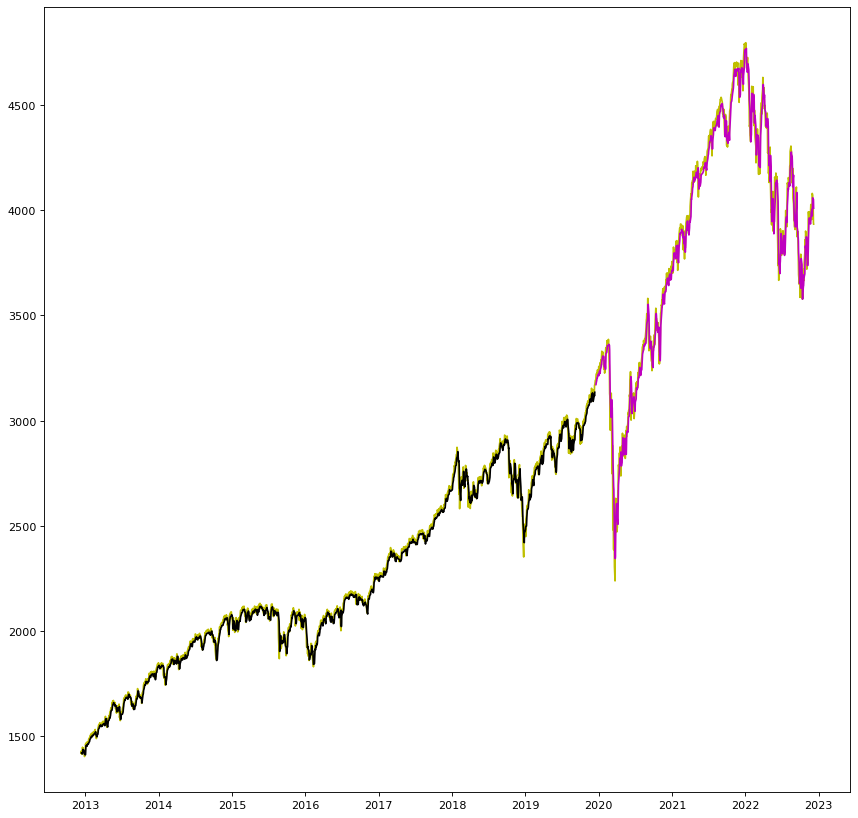

In [17]:
plt.figure(figsize=(13,13),dpi=80)
plt.plot(data['Date'],data['SP500 Daily Close'], 'y')
plt.plot(y_test_pred['Date'],y_test_pred['SP500 Pred'], 'm')
plt.plot(y_train_pred['Date'],y_train_pred['SP500 Pred'], 'k')
plt.show()